In [2]:
# pandas
import pandas as pd

# nltk for tokenization
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize

# spacy for entity rec
import spacy

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
'''
Read in .txts/.csvs of tagged sample data as a Pandas data frame
Add appropriate header to the columns as well.
'''
def read_as_df(buckets_filename, claim_id_filename, passage_filename, dir_prefix):
    claim_ids = pd.read_csv(dir_prefix+claim_id_filename, sep="\n")
    buckets = pd.read_csv(dir_prefix+buckets_filename, sep="\n")
    passages = pd.read_csv(dir_prefix+passage_filename, sep="\n")
    df_col_merged = pd.concat([claim_ids, buckets, passages], axis=1)

    return df_col_merged

In [5]:
merged = read_as_df('relic_prev_buckets.txt', 'relic_prev_ids.csv', 'relic_prev_passages.txt', 'data/relic/final-relic-annotations-2023/')

In [6]:
merged.head()

,claim_id,bucket,passage
0,13861,metaphor,The work of one moment was destroyed by the next.
1,55809,metaphor,How should they learn the entry into the finer...
2,3193,x,What is the meaning of life?
3,18123,internal character experience,His mind pictured the soldiers who would place...
4,18448,embellishing an event,He yelled then with fright and swung about. Fo...


In [7]:
def get_word_count(passage):
    return len(word_tokenize(passage))

In [8]:
def get_sentence_count(passage):
    return len(sent_tokenize(passage))

In [9]:
def get_entity_count(passage):
    doc = nlp(passage)
    return len(doc.ents)

In [10]:
def detect_first_person_passage(passage):
    passage_words = word_tokenize(passage)
    return "I" in passage_words or "me" in passage_words or "my" in passage_words or "we" in passage_words or "our" in passage_words

In [11]:
# tally word count for each passage
merged['word_count'] = merged.apply(lambda x: get_word_count(x.passage), axis=1)

In [12]:
# tally sentence count for each passage
merged['sentence_count'] = merged.apply(lambda x: get_sentence_count(x.passage), axis=1)

In [13]:
# tally named entity count for each passage
merged['named_entity_count'] = merged.apply(lambda x: get_entity_count(x.passage), axis=1)

In [14]:
# first person flag for each passage
merged['first_person'] = merged.apply(lambda x: detect_first_person_passage(x.passage), axis=1)

In [15]:
merged.head()

,claim_id,bucket,passage,word_count,sentence_count,named_entity_count,first_person
0,13861,metaphor,The work of one moment was destroyed by the next.,11,1,1,False
1,55809,metaphor,How should they learn the entry into the finer...,16,1,0,False
2,3193,x,What is the meaning of life?,7,1,0,False
3,18123,internal character experience,His mind pictured the soldiers who would place...,40,1,0,False
4,18448,embellishing an event,He yelled then with fright and swung about. Fo...,32,3,0,False


In [16]:
# median word count per group
merged.groupby(['bucket'])['word_count'].median()

bucket
embellishing an event            41.0
external characterization        45.5
informative detail               43.5
internal character experience    42.0
metaphor                         40.0
sensory detail                   56.5
x                                34.0
Name: word_count, dtype: float64

In [17]:
# 5th percentile
merged['word_count'].quantile(0.05)

13.0

In [18]:
# 95th percentile
merged['word_count'].quantile(0.95)

114.15000000000009

In [19]:
# entity count per group
merged.groupby(['bucket'])['named_entity_count'].mean()

bucket
embellishing an event            0.900277
external characterization        0.916244
informative detail               1.436073
internal character experience    0.604563
metaphor                         0.833898
sensory detail                   0.976190
x                                0.830028
Name: named_entity_count, dtype: float64

In [20]:
#fpov
to_check = ['informative detail']
fp_df = merged[(merged['first_person'] == True) & (merged['bucket'].isin(to_check))]

In [21]:
fp_df.groupby(['bucket'])['first_person'].sum()

bucket
informative detail    85
Name: first_person, dtype: int64

<AxesSubplot:>

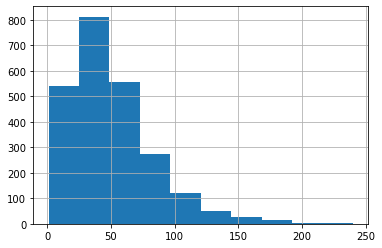

In [22]:
merged['word_count'].hist()

<AxesSubplot:>

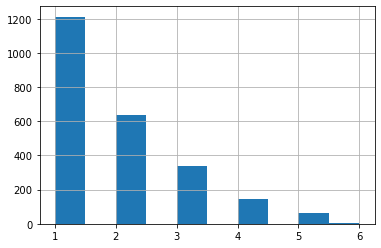

In [23]:
merged['sentence_count'].hist()

In [21]:
# sentence count per group
merged.groupby(['bucket'])['sentence_count'].mean()

bucket
embellishing an event            1.907514
external characterization        1.862944
informative detail               1.813765
internal character experience    1.853846
metaphor                         1.640411
sensory detail                   1.914676
x                                1.865204
Name: sentence_count, dtype: float64

In [24]:
# mean word count per group
merged.groupby(['bucket'])['word_count'].mean()

bucket
embellishing an event            48.437673
external characterization        51.593909
informative detail               53.817352
internal character experience    48.946768
metaphor                         46.444068
sensory detail                   63.285714
x                                42.070822
Name: word_count, dtype: float64

In [26]:
merged.sort_values(by=['word_count'], ascending=False).head(120)[['claim_id', 'bucket']]

,claim_id,bucket
1281,61039,informative detail
376,27960,x
914,66167,informative detail
2230,5162,internal character experience
1559,57665,metaphor
...,...,...
756,48223,informative detail
1632,55748,embellishing an event
1039,42222,informative detail
899,35475,informative detail


In [22]:
len(list(merged[merged['word_count'] > 114]['claim_id']))

120

In [28]:
# write out fpov .csv
fp_df.sort_values(by=['bucket'], ascending=True)[['claim_id', 'bucket', 'passage']].to_csv('data/first_person_id_passages.csv', index=False)